# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
ls NewsAggregatorDataset/

2pageSessions.csv   newsCorpora.csv     newsCorpora_re.csv  readme.txt


id title url publisher category story hostname timestamp

In [3]:
!sed -e 's/"/'\''/g' ./NewsAggregatorDataset/newsCorpora.csv > ./NewsAggregatorDataset/newsCorpora_re.csv

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df_2 = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

In [6]:
len(df_2)

13356

In [7]:
# 分割
train, val_tra = train_test_split(df_2, test_size=0.2, shuffle=True, random_state=111, stratify=df_2['CATEGORY'])
valid, test = train_test_split(val_tra, test_size=0.5, shuffle=True, random_state=111, stratify=val_tra['CATEGORY'])

In [8]:
# 保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

In [9]:
# 事例数
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
検証データ
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [10]:
import string
import re

def preprocessing(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)  # 記号をスペースに置換
    text = text.lower()  # 小文字化
    text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換
    
    return text

# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

print(df.head())

                                                  ID  \
0  Michelle Fairley Will Not Return To 'Game Of T...   
1  FOREX-New Zealand dollar pops in otherwise col...   
2  Emma Stone dazzles in plunging emerald green g...   
3  Christian Pastors Warn 'Blood Moon' Is An Omen...   
4  Oscar Pistorius trial: Court hears evidence wh...   

                                               TITLE         PUBLISHER  \
0  http   www contactmusic com in depth michelle ...  Contactmusic.com   
1  http   in reuters com article 0 0 0 markets fo...           Reuters   
2  http   www dailymail co uk tvshowbiz article 0...        Daily Mail   
3  http   www huffingtonpost com 0 0 0 blood moon...   Huffington Post   
4  http   www dailymail co uk sport othersports a...        Daily Mail   

  CATEGORY                          STORY                HOSTNAME  \
0        e  dStHXFZoe1FDTCM5XcE1IqDtD7fnM    www.contactmusic.com   
1        b  dyutEFDUhlu4tsMnZwi-wssrzIb-M          in.reuters.com   
2        e 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  # ngram_rangeでTF-IDFを計算する単語の長さを指定

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('./train.feature.txt', sep='\t', index=False)
X_valid.to_csv('./valid.feature.txt', sep='\t', index=False)
X_test.to_csv('./test.feature.txt', sep='\t', index=False)

print(X_train.head())

    0k   0m  0million   0s  0th  0th birthday  aap  aap article  abbvie  \
0  0.0  0.0       0.0  0.0  0.0           0.0  0.0          0.0     0.0   
1  0.0  0.0       0.0  0.0  0.0           0.0  0.0          0.0     0.0   
2  0.0  0.0       0.0  0.0  0.0           0.0  0.0          0.0     0.0   
3  0.0  0.0       0.0  0.0  0.0           0.0  0.0          0.0     0.0   
4  0.0  0.0       0.0  0.0  0.0           0.0  0.0          0.0     0.0   

   about  ...  yields  york  york city  you  young  your  your mother  yuan  \
0    0.0  ...     0.0   0.0        0.0  0.0    0.0   0.0          0.0   0.0   
1    0.0  ...     0.0   0.0        0.0  0.0    0.0   0.0          0.0   0.0   
2    0.0  ...     0.0   0.0        0.0  0.0    0.0   0.0          0.0   0.0   
3    0.0  ...     0.0   0.0        0.0  0.0    0.0   0.0          0.0   0.0   
4    0.0  ...     0.0   0.0        0.0  0.0    0.0   0.0          0.0   0.0   

   zac  zac efron  
0  0.0        0.0  
1  0.0        0.0  
2  0.0        

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logi = LogisticRegression(random_state=0, max_iter=10000)
logi.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=0)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [14]:
import numpy as np

def score_lg(lg, X):
    return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [15]:
train_pred = score_lg(logi, X_train)
test_pred = score_lg(logi, X_test)

print(train_pred)

[array([0.99014854, 0.99112755, 0.98694342, ..., 0.9859995 , 0.99365216,
       0.91566219]), array(['e', 'b', 'e', ..., 'b', 'e', 'b'], dtype=object)]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
tra_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])

In [18]:
tes_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

In [19]:
print(f'学習データ 正解率：{tra_accuracy:.3f}')
print(f'評価データ 正解率：{tes_accuracy:.3f}')

学習データ 正解率：0.908
評価データ 正解率：0.884


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

### 混同行列
機械学習の評価指標

![cm.png](cm.png)

正解率：(TP+TN) / (TP+FN+FP+TN)

検出率：TP / (TP+FN)

精度：TP / (TP+FP)

誤検出率：FP / (FP+TN)

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[[4301   98   18   84]
 [ 105 4116    5    9]
 [ 129  120  448   31]
 [ 253  125    5  837]]


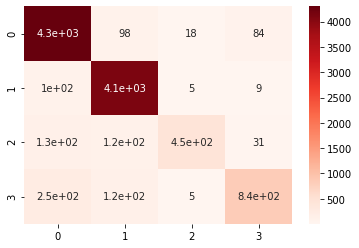

In [21]:
# trainデータ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Reds')
plt.show()

[[529  21   2  11]
 [ 15 513   1   1]
 [ 22  18  44   7]
 [ 36  17   4  95]]


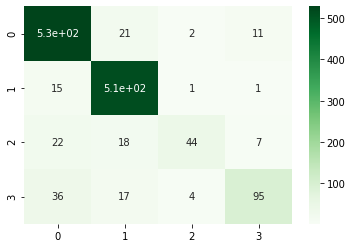

In [22]:
# testデータ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Greens')
plt.show()

## 56. 適合率、再現率、F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [24]:
def calculate_scores(y_true, y_pred):
    # 適合率
    precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))
    
    # 再現率
    recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))
    
    # F1スコア
    f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))
    
    scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
    
    return scores

In [25]:
print(calculate_scores(test['CATEGORY'], test_pred[1]))

             適合率       再現率     F1スコア
b       0.878738  0.939609  0.908155
e       0.901582  0.967925  0.933576
t       0.833333  0.625000  0.714286
m       0.862745  0.483516  0.619718
マイクロ平均  0.883982  0.883982  0.883982
マクロ平均   0.869099  0.754013  0.793934


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [26]:
features = X_train.columns.values
index = [i for i in range(1, 11)]

for c, coef in zip(logi.classes_, logi.coef_):
    print(f'カテゴリ：{c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重みの高い特徴量トップ10'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重みの低い特徴量トップ10'], index=index).T
    display(pd.concat([best10, worst10], axis=0))

カテゴリ：b


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,economy,markets,bank,results,fed,obamacare,ukraine,article markets,ecb,china
重みの低い特徴量トップ10,www contactmusic,contactmusic,contactmusic com,ebola,music,microsoft,fda,aereo,apple,study


カテゴリ：e


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,contactmusic,contactmusic com,www contactmusic,entertainment,music,tvshowbiz,uk tvshowbiz,tvshowbiz article,television,film
重みの低い特徴量トップ10,businessweek com,businessweek,www businessweek,sciencetech article,sciencetech,uk sciencetech,health,com news,reuters,reuters com


カテゴリ：m


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,ebola,health,fda,study,cancer,mers,anthrax,medical,virus,hiv
重みの低い特徴量トップ10,results,gm,facebook,media,climate,entertainment,google,economy,tvshowbiz,amazon


カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,google,apple,facebook,microsoft,climate,fcc,internet,heartbleed,gm,space
重みの低い特徴量トップ10,health,markets,article markets,entertainment,tvshowbiz,tvshowbiz article,uk tvshowbiz,fda,people,contactmusic com


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [27]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    # モデルの学習
    lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])
    
    # 予測値の取得
    train_pred = score_lg(lg, X_train)
    valid_pred = score_lg(lg, X_valid)
    test_pred = score_lg(lg, X_test)
    
    # 正解率の算出
    train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
    test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
    
    # 結果の格納
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [10:12<00:00, 61.29s/it] 


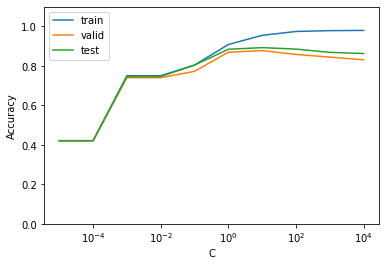

In [28]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ

In [29]:
import xgboost as xgb

params={'objective': 'multi:softmax', 
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'colsample_bytree': 1.0, 
        'colsample_bylevel': 0.5,
        'min_child_weight': 1,
        'subsample': 0.9, 
        'eta': 0.1, 
        'max_depth': 5,
        'gamma': 0.0,
        'alpha': 0.0,
        'lambda': 1.0,
        'num_round': 1000,
        'early_stopping_rounds': 50,
        'verbosity': 0
        }

# XGBoost用にフォーマット変換
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x])
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x])
y_test = test['CATEGORY'].map(lambda x: category_dict[x])
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# モデルの学習
num_round = params.pop('num_round')
early_stopping_rounds = params.pop('early_stopping_rounds')
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.27118	eval-mlogloss:1.27504
[1]	train-mlogloss:1.17540	eval-mlogloss:1.18330
[2]	train-mlogloss:1.09644	eval-mlogloss:1.10716
[3]	train-mlogloss:1.02869	eval-mlogloss:1.04312
[4]	train-mlogloss:0.97077	eval-mlogloss:0.98767
[5]	train-mlogloss:0.92048	eval-mlogloss:0.93945
[6]	train-mlogloss:0.87619	eval-mlogloss:0.89705
[7]	train-mlogloss:0.83730	eval-mlogloss:0.86068
[8]	train-mlogloss:0.80334	eval-mlogloss:0.82843
[9]	train-mlogloss:0.77296	eval-mlogloss:0.79995
[10]	train-mlogloss:0.74596	eval-mlogloss:0.77509
[11]	train-mlogloss:0.72115	eval-mlogloss:0.75176
[12]	train-mlogloss:0.69938	eval-mlogloss:0.73185
[13]	train-mlogloss:0.67947	eval-mlogloss:0.71337
[14]	train-mlogloss:0.66196	eval-mlogloss:0.69625
[15]	train-mlogloss:0.64599	eval-mlogloss:0.68113
[16]	train-mlogloss:0.63157	eval-mlogloss:0.66727
[17]	train-mlogloss:0.61823	eval-mlogloss:0.65549
[18]	train-mlogloss:0.60646	eval-mlogloss:0.64495
[19]	train-mlogloss:0.59620	eval-mlogloss:0.63485
[20]	train

In [30]:
# 予測値の取得
train_pred = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
valid_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
test_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

# 正解率の算出
train_accuracy = accuracy_score(y_train, train_pred) 
valid_accuracy = accuracy_score(y_valid, valid_pred) 
test_accuracy = accuracy_score(y_test, test_pred) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

/usr/local/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


正解率（学習データ）：0.946
正解率（検証データ）：0.862
正解率（評価データ）：0.870
